# Purpose
This project focuses on classifying tweets based on whether they are about disasters or not. Certain words, like 'ablaze' can refer to a disaster (wildfire) or metaphorically (sunset). For this reason natural language processing is an important component. Individual words have to be considered in their context in order to accurately classify the tweets.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

# NLTK
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

#Keras and Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional


[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [47]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


# EDA and Cleaning
I began with examining the shape of each dataframe, as well as the head of the training dataframe. The training set contains 7,613 tweets and the test set contains 3,263 tweets. Each tweet has an id, keyword, location, and text feature. The training set also has the target feature (1 for disaster, 0 for nondisaster). I began the cleaning process by looking for null and unique values.

In [48]:
print("Training shape:", train.shape)
print("Test shape:", test.shape)

train.head()

Training shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Null and unique values
Approximately a third of values in location are null, so that column will be dropped. Since the planned model focuses on text analysis, I also dropped the keyword column. There are duplicate tweets, so those will also be dropped.

In [49]:
# Check for null values
print(train.isnull().sum()/len(train))
train.drop('location', axis = 1, inplace = True)
train.drop('keyword', axis = 1, inplace = True)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64


In [50]:
# Check for unique values
print(train.nunique()/len(train))

# Check duplicate tweets
duplicates = train['text'].duplicated(keep = False)
print(train[duplicates])

# Delete duplicates
train['text'].drop_duplicates(inplace = True)

id        1.000000
text      0.985551
target    0.000263
dtype: float64
         id                                               text  target
40       59  Check these out: http://t.co/rOI2NSmEJJ http:/...       0
48       68  Check these out: http://t.co/rOI2NSmEJJ http:/...       0
106     156  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
115     165  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
118     171  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0
...     ...                                                ...     ...
7600  10855  Evacuation order lifted for town of Roosevelt:...       1
7607  10867  #stormchase Violent Record Breaking EF-5 El Re...       1
7609  10870  @aria_ahrary @TheTawniest The out of control w...       1
7610  10871  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611  10872  Police investigating after an e-bike collided ...       1

[179 rows x 3 columns]


### Class distribution
There are more non-disaster (57%) than disaster (43%) tweets.

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Disaster vs. Non-Disaster Tweets')

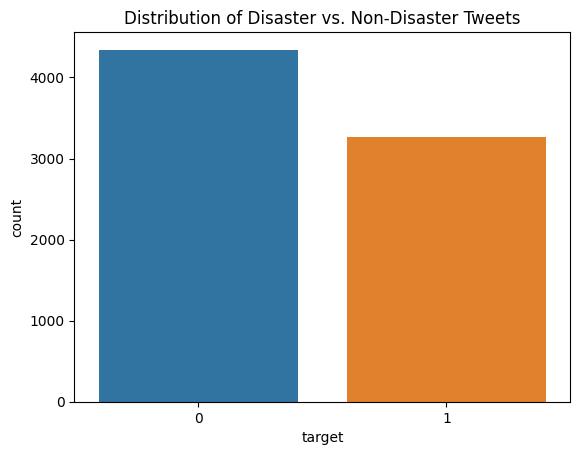

In [51]:
# Histogram of each class
print(train['target'].value_counts(normalize = True))

sns.countplot(train, x = 'target')
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')

## Preprocessing
Before continuing with further EDA, I used NLTK because it has more functionalities for processing text than Keras preprocessing.
Steps:
- Remove stop words
- Lemmatize
- Convert to lowercase

In [52]:
# Function to preprocess the text
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    text = word_tokenize(text)
    text = [word for word in text if word.casefold() not in set(stopwords.words('english')) and word.isalpha()]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [53]:
# Apply preprocessing

train['clean_text'] = train['text'].apply(lambda txt: preprocess(txt))
test['clean_text'] = test['text'].apply(lambda txt: preprocess(txt))
train['clean_text'].head()

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked place notified officer evacuati...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: clean_text, dtype: object

### Tokenization and Sequencing
I used the Keras preprocessing module to prepare the text for embedding.

In [54]:
# Tokenize
vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(train['clean_text'])
X_test_sequences = tokenizer.texts_to_sequences(test['clean_text'])

# Pad sequences to make them of equal lengths
max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_length, padding='post')


### Word Embedding with Word2Vec

Word embedding allows for the representation of words as vectors of numbers. There are two basic types of word embeddings: frequency-based and prediction-based.\
Frequency-based: uses the count of words within the text or texts
- Count vectorization: produces a sparse matrix of the frequencies of the words in the document
- TF-IDF vectorization: improves upon count vectorization by weighting the words based on their frequency across documents. This increases the weight of words that occur frequently within a subset of documnets, but not across the documents as a whole. These words are likely to be relevant to the topic or meaning of the document\
Prediction-based: semantically similar words are close together
- Word2Vec: uses the continuous bag of words and continuous skip-gram models. The CBOW model predicts a target word when given the surrounding words. The skip-gram model predicts the surrounding words when given a target word
- GloVe: constructs a matrix of co-occurence information about words and their context and uses matrix factorization to generate a vector for each word\
This project will use pre-trained Word2Vec embeddings.

In [55]:
word2vec = api.load('word2vec-google-news-300')

embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
     if word in word2vec:
        embedding_matrix[i] = word2vec[word]

## Further EDA
After preprocessing the text, I continued exploring the data. I chose to create word clouds and frequency distributions on the preprocessed text because it provided more meaningful results and reflected the words that will be included in the model.

### Word clouds

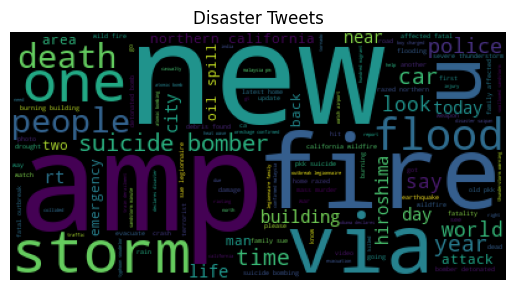

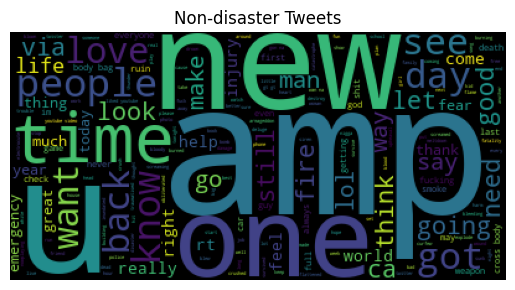

In [56]:
# Split disaster and non-disaster tweets
disaster_tweets = train[train['target'] == 1]['clean_text'].values
non_disaster_tweets = train[train['target'] == 0]['clean_text'].values



tcloud = WordCloud().generate(' '.join(disaster_tweets))
plt.axis('off')
plt.title('Disaster Tweets')
plt.imshow(tcloud)
plt.show()

fcloud = WordCloud().generate(' '.join(non_disaster_tweets))
plt.axis('off')
plt.title('Non-disaster Tweets')
plt.imshow(fcloud)

### Frequency distributions
In order to create frequency distributions for each set of tweets, I created a corpus for each set and use NLTK to view frequent ngrams. I created a table to show the most frequent single words, bigrams, and trigrams for each set.

In [57]:
# Create corpus
def corpus(df):
    corpus = []
    for tweet in df:
        for tweet in df['clean_text']:
            tweet = word_tokenize(tweet)
            for word in tweet:
                corpus.append(word)
    return corpus
true_corpus = corpus(train[train['target'] == 1])
false_corpus = corpus(train[train['target'] == 0])

In [58]:
# Function to remove common words between two sets
def delete_common(disaster, non_disaster):
    common_words = set(disaster).intersection(non_disaster)
    for word in common_words:
        del disaster[word]
        del non_disaster[word]
        
# Single words
disasterfd = nltk.FreqDist(true_corpus)
non_disasterfd = nltk.FreqDist(false_corpus)

delete_common(disasterfd, non_disasterfd)

# Bigrams
disaster_bigrams = nltk.collocations.BigramCollocationFinder.from_words([word for word in true_corpus])
non_disaster_bigrams = nltk.collocations.BigramCollocationFinder.from_words([word for word in false_corpus])

delete_common(disaster_bigrams.ngram_fd, non_disaster_bigrams.ngram_fd)

# Trigrams
disaster_trigrams = nltk.collocations.TrigramCollocationFinder.from_words([word for word in true_corpus])
non_disaster_trigrams = nltk.collocations.TrigramCollocationFinder.from_words([word for word in false_corpus])

delete_common(disaster_trigrams.ngram_fd, non_disaster_trigrams.ngram_fd)

# Table of disaster ngrams
ngram_df = pd.DataFrame({'1': disasterfd.most_common(20), 
                         '2': disaster_bigrams.ngram_fd.most_common(20), 
                         '3': disaster_trigrams.ngram_fd.most_common(20)})
ngram_df

,1,2,3
0,"(northern, 256)","((suicide, bomber), 240)","((suicide, bomber, detonated), 120)"
1,"(legionnaire, 244)","((northern, california), 164)","((northern, california, wildfire), 116)"
2,"(debris, 200)","((california, wildfire), 140)","((latest, home, razed), 112)"
3,"(severe, 188)","((suicide, bombing), 128)","((home, razed, northern), 112)"
4,"(migrant, 184)","((bomber, detonated), 120)","((pkk, suicide, bomber), 112)"
5,"(derailment, 160)","((home, razed), 116)","((bomber, detonated, bomb), 112)"
6,"(investigator, 144)","((severe, thunderstorm), 112)","((razed, northern, california), 108)"
7,"(mosque, 140)","((latest, home), 112)","((old, pkk, suicide), 108)"
8,"(pkk, 124)","((razed, northern), 112)","((family, sue, legionnaire), 104)"
9,"(detonated, 124)","((pkk, suicide), 112)","((family, affected, fatal), 104)"


In [59]:
# Table of non-disaster ngrams
non_ngram_df = pd.DataFrame({'1': non_disasterfd.most_common(20), 
                         '2': non_disaster_bigrams.ngram_fd.most_common(20), 
                         '3': non_disaster_trigrams.ngram_fd.most_common(20)})
non_ngram_df

,1,2,3
0,"(lmao, 64)","((wreck, wreck), 52)","((wreck, wreck, wreck), 44)"
1,"(career, 60)","((stock, http), 44)","((top, pay, pile), 40)"
2,"(disney, 60)","((top, pay), 40)","((rise, top, pay), 36)"
3,"(character, 56)","((pay, pile), 40)","((http, view, download), 36)"
4,"(louis, 48)","((panic, attack), 40)","((view, download, video), 36)"
5,"(edm, 44)","((aftershock, http), 36)","((fan, army, beyhive), 32)"
6,"(welcome, 44)","((every, time), 36)","((army, beyhive, http), 32)"
7,"(lucky, 44)","((http, view), 36)","((ir, icemoon, aftershock), 28)"
8,"(complete, 44)","((view, download), 36)","((icemoon, aftershock, http), 28)"
9,"(ticket, 44)","((download, video), 36)","((aftershock, http, djicemoon), 28)"


# Models
This project will compare 3 different RNN models:
- LSTM
- GRU
- BiLSTM\
Each model will follow a similar basic architecture:
- Embedding layer
- RNN layer
- Dropout layer
- Dense layer

### LSTM (Long Short Term Memory)
Standard RNN are vunlerable to vanishing or exploding gradients. The LSTM avoids this problem by using one path for short-term memory and one path for long-term memory. It employs several gates, which allow modification of the information passing through the model.
- Forget: determine information to be dropped
- Input: determine information to be added
- Update: completes the updates determined by forget and input layers
- Output: prepares the information to be passed along

In [60]:
model_lstm = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 64),
    LSTM(128),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_lstm.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### GRU (Gated Recurrent Unit)
GRU is a variant of LSTM in which the forget and input gates are combined into a reset gate. This results in a simpler model.

In [61]:
model_gru = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 64),
    GRU(128),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model_gru.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_gru.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### BiLSTM (Bidirectional LSTM)
A BiLSTM uses 2 LSTM layers. One processes information in the forward direction and the other in the backward direction. In this way, it better learns the relationship between sequences.

In [62]:
model_bi_lstm = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 64),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model_bi_lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_bi_lstm.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

In [63]:
# Split the data into training and validation sets
X_train, X_val, y_train_split, y_val = train_test_split(X_train_padded, train['target'].values, test_size=0.2, random_state=42)

In [64]:
#Model 1: LSTM
history_lstm = model_lstm.fit(X_train, y_train_split, epochs = 5, batch_size = 36, validation_data = (X_val, y_val))

#Model 2: GRU
history_gru = model_gru.fit(X_train, y_train_split, epochs = 5, batch_size = 36, validation_data = (X_val, y_val))

#Model 3: Bidirectional LSTM
history_bi_lstm = model_bi_lstm.fit(X_train, y_train_split, epochs = 5, batch_size = 36, validation_data = (X_val, y_val))

Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.5672 - loss: 0.6858 - val_accuracy: 0.5739 - val_loss: 0.6837
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.5704 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5808 - loss: 0.6814 - val_accuracy: 0.5739 - val_loss: 0.6840
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5783 - loss: 0.6826 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.5829 - loss: 0.6806 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - accuracy: 0.5542 - loss: 0.6875 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.5681 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6851
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5668 - loss: 0.6856 - 

## Evaluation
The accuracy and loss for each model is plotted below. LSTM and GRU show little change in accuracy across epochs and both perform better on the validation data. The loss values are also lower for the validation data. For BiLSTM, training accuracy increases across epochs, while validation accuracy decreases. Similarly, the training loss value decreases across epochs, while validation loss increases. This shows that the model is less effective on the validation data as epochs increase. This may indicate that the model is starting to overfit in later epochs.

In [65]:
# Plotting functions
def plot(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label = 'Train')
    plt.plot(history.history['val_accuracy'], label = 'Val')
    plt.title(model_name + ' Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label = 'Train')
    plt.plot(history.history['val_loss'], label = 'Val')
    plt.title(model_name + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

### LSTM

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5694 - loss: 0.6838
LSTM Validation Accuracy:  0.5738673806190491


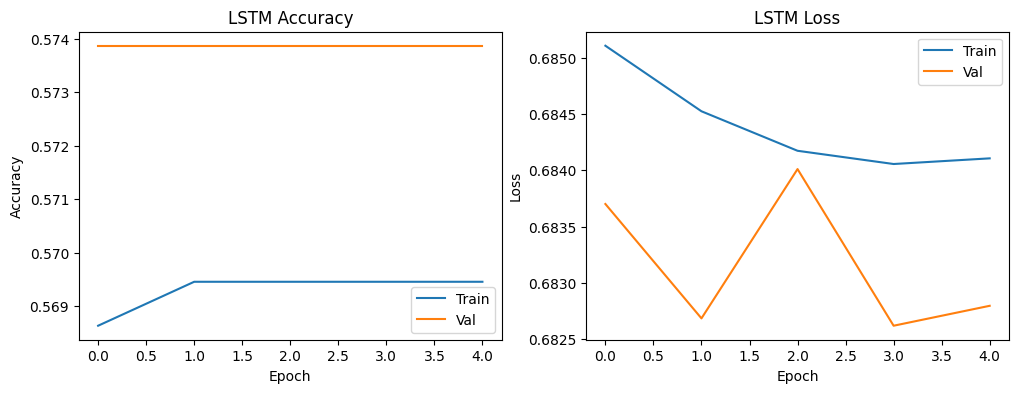

In [66]:
val_loss_lstm, val_acc_lstm = model_lstm.evaluate(X_val, y_val)

plot(history_lstm, 'LSTM')

print('LSTM Validation Accuracy: ', val_acc_lstm)

#### GRU

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5694 - loss: 0.6842
GRU Validation Accuracy:  0.5738673806190491


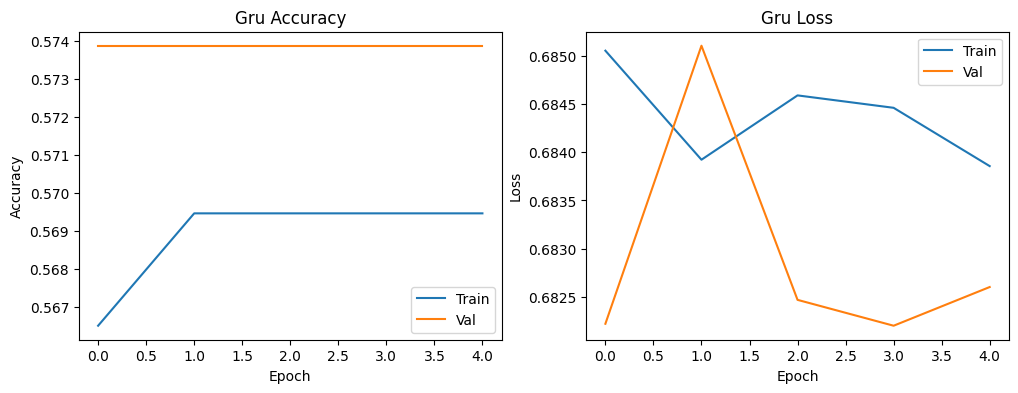

In [67]:
val_loss_gru, val_acc_gru = model_gru.evaluate(X_val, y_val)

plot(history_gru, 'Gru')

print('GRU Validation Accuracy: ', val_acc_gru)

#### BiLSTM

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7232 - loss: 0.7448
Bidirectional LSTM Validation Accuracy:  0.7524622678756714


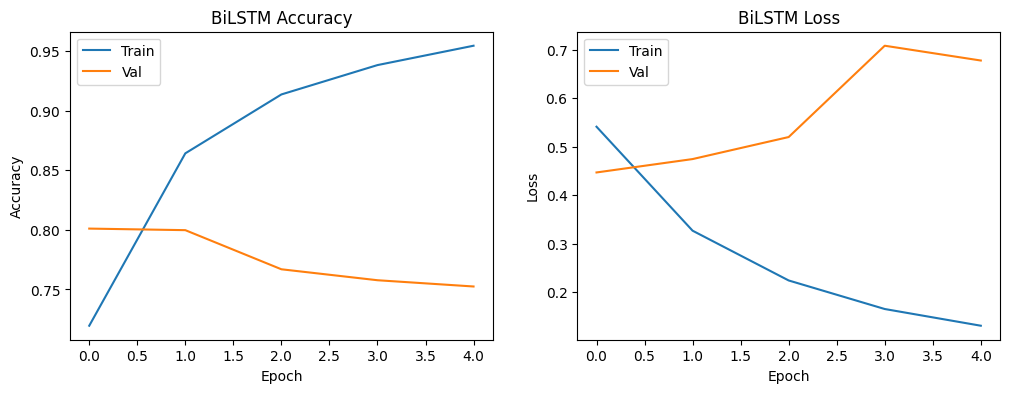

In [68]:
val_loss_bi_lstm, val_acc_bi_lstm = model_bi_lstm.evaluate(X_val, y_val)

plot(history_bi_lstm, 'BiLSTM')

print('Bidirectional LSTM Validation Accuracy: ', val_acc_bi_lstm)

### Comparison
The table below shows the validation accuracy and loss for each model. The BiLSTM clearly outperforms both of the other models with an accuracy of 0.75. 

In [69]:
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'BiLSTM'],
    'Validation Accuracy': [val_acc_lstm, val_acc_gru, val_acc_bi_lstm],
    'Validation Loss': [val_loss_lstm, val_loss_gru, val_loss_bi_lstm]
})

results

,Model,Validation Accuracy,Validation Loss
0,LSTM,0.573867,0.682796
1,GRU,0.573867,0.682600
2,BiLSTM,0.752462,0.677560


# Conclusion
The BiLSTM was the most effective. The semantic relationships are very important for distinguishing between the two categories in this project, so the BiLSTM is well suited since it processes sequences in both directions. For further investigation, other word embeddings, such as GloVe could be compared.

### Submission
The code below creates a set of predictions and prepares them for submission.

In [70]:
predictions = model_bi_lstm.predict(X_test_padded)
predictions = (predictions > 0.5).astype(int).reshape(-1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step


In [71]:
# Create submission
submission = pd.DataFrame({'id': test['id'], 'target': predictions})
submission.to_csv('submission.csv', index = False)

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


# References
- https://www.kaggle.com/code/ashishpatel26/word-embedding-with-beginner-to-advance
- https://towardsdatascience.com/simple-word-embedding-for-natural-language-processing-5484eeb05c06
- https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/
- https://www.ibm.com/topics/word-embeddings
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
